In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stat
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from sklearn.impute import KNNImputer

In [135]:
def load_data(url):
    df = pd.read_excel(url, skiprows=4, header=[0])
    df.drop(columns=['EASEMENT'], inplace=True) #Removing the Empty Column
    return df
df = load_data('C:/Users/Sameer/Internee/Data/rollingsales_bronx.xlsx')
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,2907,24,A1,4090 PARK AVENUE,NaN,10457,1.0,0.0,1.0,2500.0,1474.0,1901.0,1,A1,0,2024-03-28
1,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3030,66,A1,4453 PARK AVENUE,NaN,10457,1.0,0.0,1.0,1646.0,1497.0,1899.0,1,A1,570000,2023-08-23
2,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3046,27,A1,2090 WASHINGTON AVENUE,NaN,10457,1.0,0.0,1.0,2356.0,2213.0,1901.0,1,A1,0,2024-06-11
3,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3046,40,A1,2073 BATHGATE AVENUE,NaN,10457,1.0,0.0,1.0,1933.0,1344.0,1899.0,1,A1,425000,2024-06-27
4,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3047,11,A1,482 EAST 181ST STREET,NaN,10457,1.0,0.0,1.0,1556.0,1240.0,1901.0,1,A1,0,2024-06-14


In [136]:
def clean_column_names(df):
    new_cols =  []
    for column in df:
        proper_cols = column.title()
        proper_cols_hyphen = proper_cols.replace(' ','_')
        clean_cols = proper_cols_hyphen.replace('-','_')
        new_cols.append(clean_cols)
    df.columns = new_cols
    return df
df = clean_column_names(df)

In [137]:
#univariate statistics
def univariate_stats(df):
    df_output = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'Numeric', 'Mode', 'Mean', 'Min', '25%', 'Median',
                                     '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    for col in df:
        count = df[col].count()
        missing = df[col].isnull().sum()
        unique = df[col].nunique()
        dtype = df[col].dtype
        mode = df[col].mode().values[0] 
        if pd.api.types.is_numeric_dtype(df[col]):
            mean = df[col].mean() 
            min = df[col].min() 
            quantile25 = df[col].quantile(0.25) 
            median = df[col].median()
            quartile75 = df[col].quantile(0.75)
            max_val = df[col].max() 
            std = df[col].std()
            skew = df[col].skew()
            kurt = df[col].kurt()
            df_output.loc[col] = [count, missing, unique, dtype,pd.api.types.is_numeric_dtype(df[col]),mode,
                                  mean, min,quantile25, median, quartile75,max_val,std,skew,kurt]
        else:
            df_output.loc[col] = [count, missing, unique, dtype,pd.api.types.is_numeric_dtype(df[col]),mode,
                                  '-','-','-','-','-','-','-','-','-']
    return df_output.sort_values(by = ['Numeric', 'Skew', 'Unique'], ascending=False)

univariate_stats(df)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Commercial_Units,4161,1621,12,float64,True,0.0,1.241769,0.0,0.0,0.0,0.0,252.0,16.546894,15.066524,225.537532
Land_Square_Feet,4134,1648,1587,float64,True,2500.0,29839.763425,0.0,2117.0,2500.0,3536.0,5612000.0,374196.725993,14.615867,213.888434
Gross_Square_Feet,4134,1648,1671,float64,True,0.0,9799.747944,0.0,1584.0,2184.0,3099.5,1172005.0,80393.332079,13.67983,191.365194
Residential_Units,4638,1144,83,float64,True,1.0,3.125485,0.0,1.0,2.0,2.0,278.0,10.470483,12.328221,220.323357
Total_Units,4665,1117,79,float64,True,1.0,4.215005,0.0,1.0,2.0,2.0,279.0,18.671711,11.17798,138.828525
Sale_Price,5782,0,1022,int64,True,0,675991.801107,0,0.0,300000.0,750000.0,27018000,1480183.117192,7.118629,82.844741
Lot,5782,0,840,int64,True,1,311.405223,1,23.25,50.0,138.75,5377,761.440012,3.808254,15.328272
Tax_Class_At_Time_Of_Sale,5782,0,3,int64,True,1,1.486683,1,1.0,1.0,2.0,4,0.771001,1.924805,3.651793
Year_Built,5180,602,121,float64,True,1920.0,1946.277413,1897.0,1925.0,1945.0,1961.0,2023.0,28.960021,0.572362,-0.193018
Borough,5782,0,1,int64,True,2,2.0,2,2.0,2.0,2.0,2,0.0,0,0


In [138]:
# #Converting Year_Built to str
df.Year_Built = df.Year_Built.astype('str')
df.dtypes

Borough                                    int64
Neighborhood                              object
Building_Class_Category                   object
Tax_Class_At_Present                      object
Block                                      int64
Lot                                        int64
Building_Class_At_Present                 object
Address                                   object
Apartment_Number                          object
Zip_Code                                   int64
Residential_Units                        float64
Commercial_Units                         float64
Total_Units                              float64
Land_Square_Feet                         float64
Gross_Square_Feet                        float64
Year_Built                                object
Tax_Class_At_Time_Of_Sale                  int64
Building_Class_At_Time_Of_Sale            object
Sale_Price                                 int64
Sale_Date                         datetime64[ns]
dtype: object

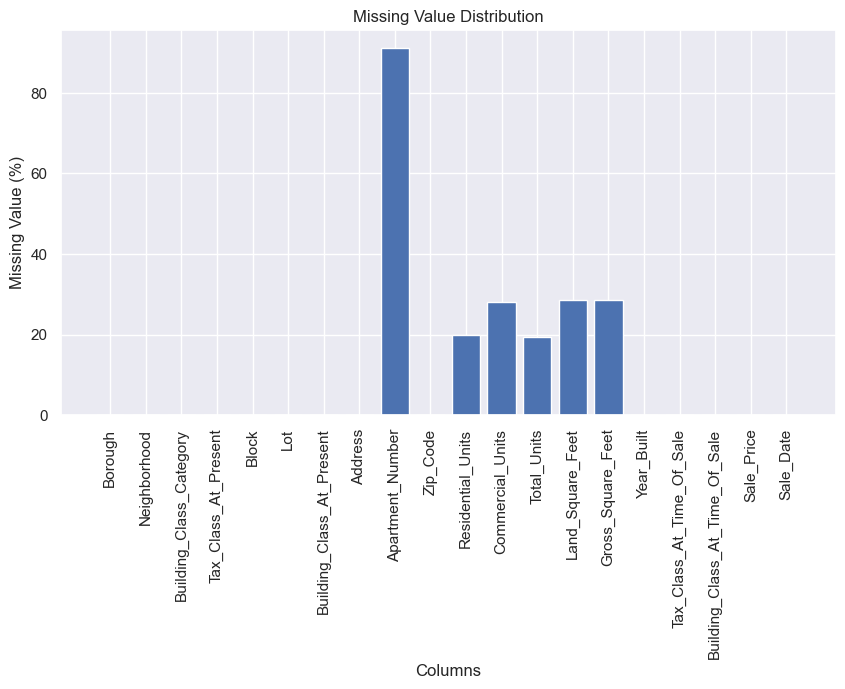

In [139]:
#Missing Value Distribution Visualization
missing_values = df.isnull().sum() / len(df) * 100
plt.figure(figsize = (10,5))
plt.bar(missing_values.index, missing_values.values)
plt.xlabel('Columns')
plt.ylabel('Missing Value (%)')
plt.xticks(rotation=90)
plt.title('Missing Value Distribution')
plt.show()

In [140]:
missing_values = round(missing_values,1)
missing_values

Borough                            0.0
Neighborhood                       0.0
Building_Class_Category            0.0
Tax_Class_At_Present               0.0
Block                              0.0
Lot                                0.0
Building_Class_At_Present          0.0
Address                            0.0
Apartment_Number                  91.0
Zip_Code                           0.0
Residential_Units                 19.8
Commercial_Units                  28.0
Total_Units                       19.3
Land_Square_Feet                  28.5
Gross_Square_Feet                 28.5
Year_Built                         0.0
Tax_Class_At_Time_Of_Sale          0.0
Building_Class_At_Time_Of_Sale     0.0
Sale_Price                         0.0
Sale_Date                          0.0
dtype: float64

In [141]:
#Dropping Column with missing value greater then 30%
drop_cols = missing_values[missing_values > 30].index
df.drop(columns=drop_cols, inplace=True)

In [142]:
#Dropping the Borough Column as It’s redundant and does not contribute to the analysis 
df.drop(columns=['Borough'], inplace=True)

In [143]:
# #Replace Columns with missing value less than 30
knn_imputer = KNNImputer(n_neighbors=5)

replace_col = missing_values[(missing_values > 1) & (missing_values <= 30)].index

knn_cols = [col for col in replace_col if col != 'Year_Built']

if knn_cols:
    df_knn = df[knn_cols]  # Extract columns to be imputed
    df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=knn_cols, index=df.index)
    df[knn_cols] = df_knn_imputed
    
if 'Year_Built' in replace_col:
    df['Year_Built'].fillna(df['Year_Built'].median(), inplace=True)

In [144]:
replace_col

Index(['Residential_Units', 'Commercial_Units', 'Total_Units',
       'Land_Square_Feet', 'Gross_Square_Feet'],
      dtype='object')

In [145]:
def anova(df, feature, label):
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    grouped_labels = []
    for group in groups:
        g_list = df_grouped.get_group(group)
        grouped_labels.append(g_list[label])
    return stats.f_oneway(*grouped_labels)

In [146]:
def heteroscedasticity(df, feature, label):
    formula = f"{label}~{feature}"
    model = ols(formula=formula, data=df).fit()
    
    output_df = pd.DataFrame(columns=['LM stats', 'LM p', 'F stat', 'F stat p'])
    try:
        white_test = het_white(model.resid, model.model.exog)
        output_df.loc['White'] = white_test
    except:
        print("Unable to run White test of heteroscedasticity")
    breuschpagan_test = het_breuschpagan(model.resid, model.model.exog)
    output_df.loc['Br-pa'] = breuschpagan_test
    return output_df.round(3)

def scatter(feature,label):
    m, b, r, p, err = stats.linregress(feature, label)
    
    textstr = 'y = ' + str(round(m,2)) + 'x + ' +  str(round(b,2)) + ' \n'
    textstr += 'r2 = ' + str(round(r**2, 2)) + '\n'
    textstr += 'p = ' + str(round(p,2)) + '\n'
    textstr += str(feature.name) + " skew = " + str(round(feature.skew(),2)) + '\n'
    textstr += str(label.name) + " skew = " + str(round(label.skew(),2))+ '\n'
    textstr += str(heteroscedasticity(pd.DataFrame(label).join(pd.DataFrame(feature)), feature.name, label.name))
    
    sns.set(color_codes = True)
    ax = sns.jointplot(x = feature, y = label, kind = 'reg');
    ax.fig.text(1, 0.114, textstr, fontsize=12, transform= plt.gcf().transFigure)
    plt.show()


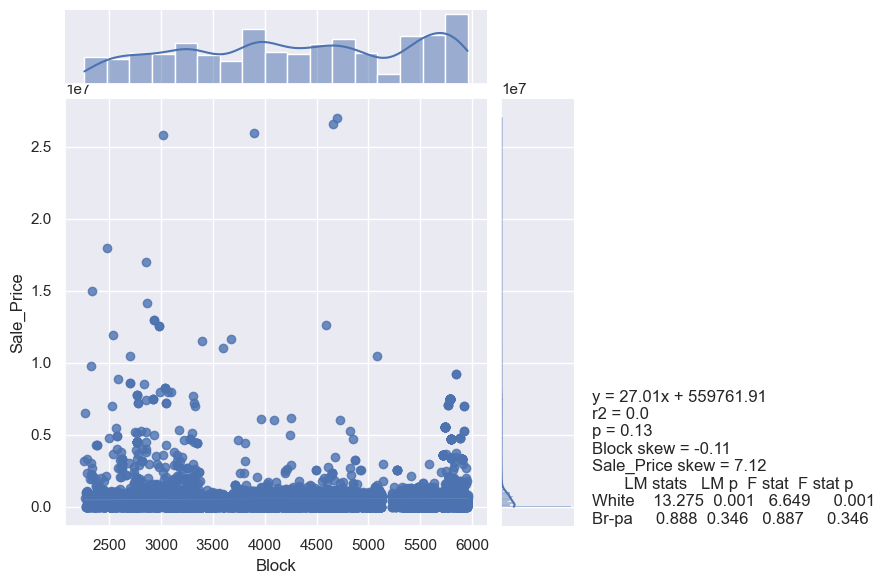

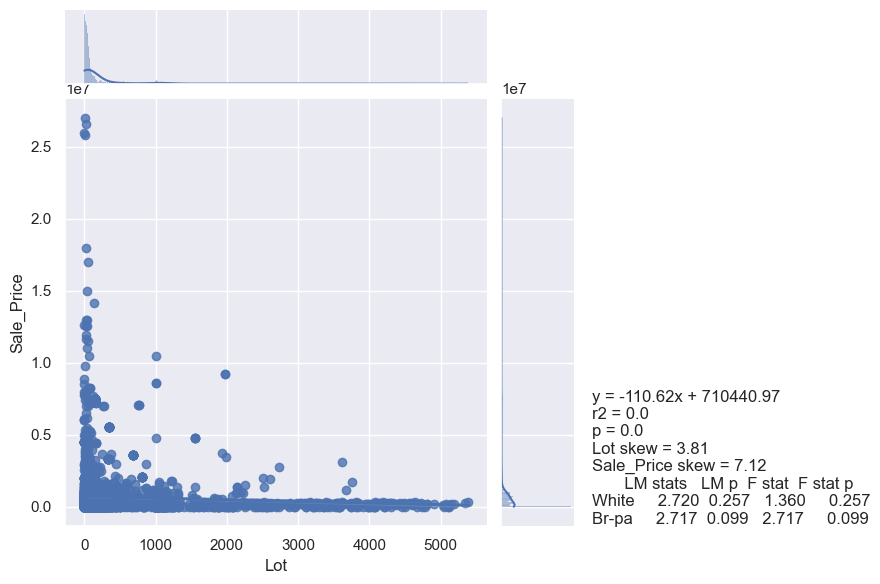

Unable to run White test of heteroscedasticity


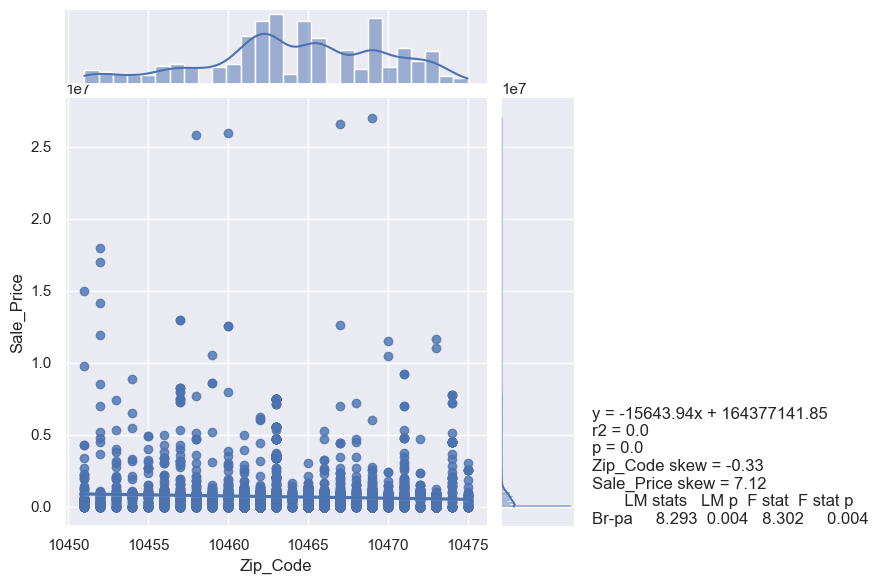

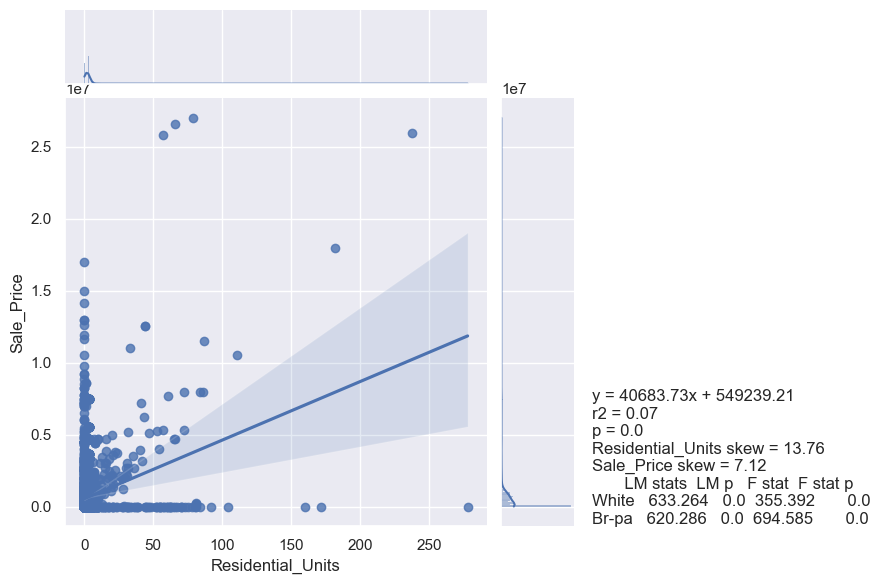

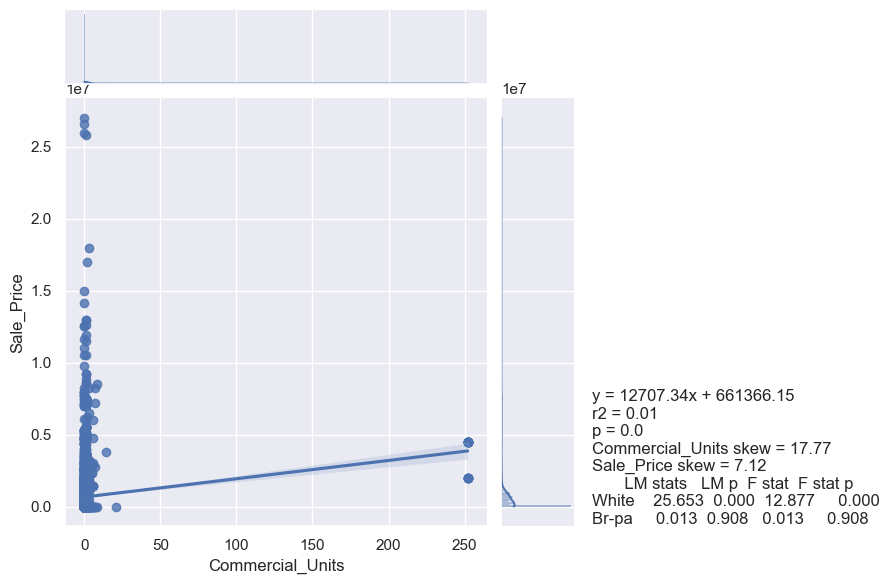

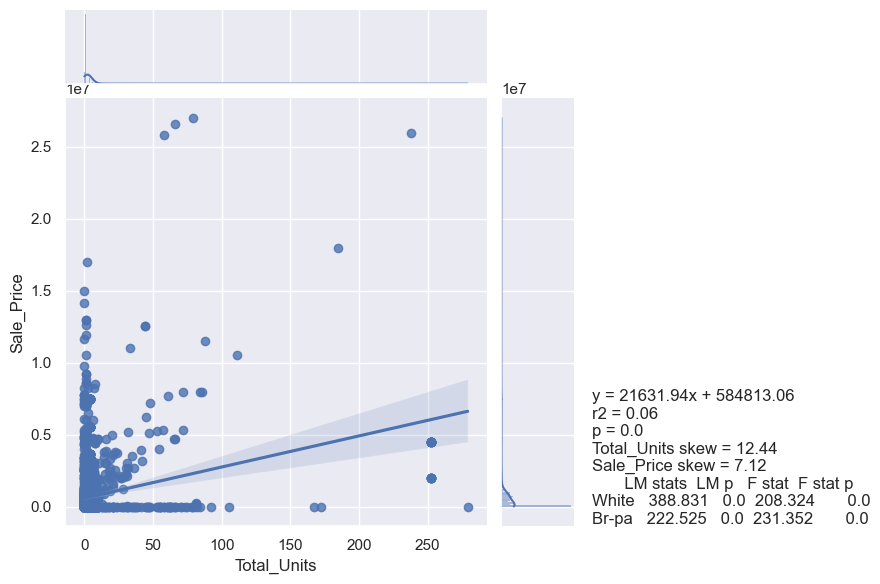

Unable to run White test of heteroscedasticity


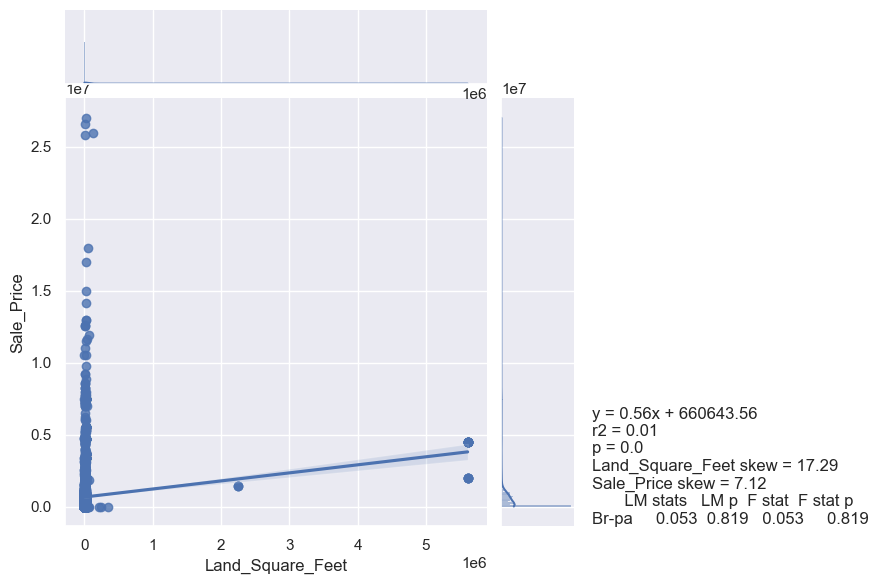

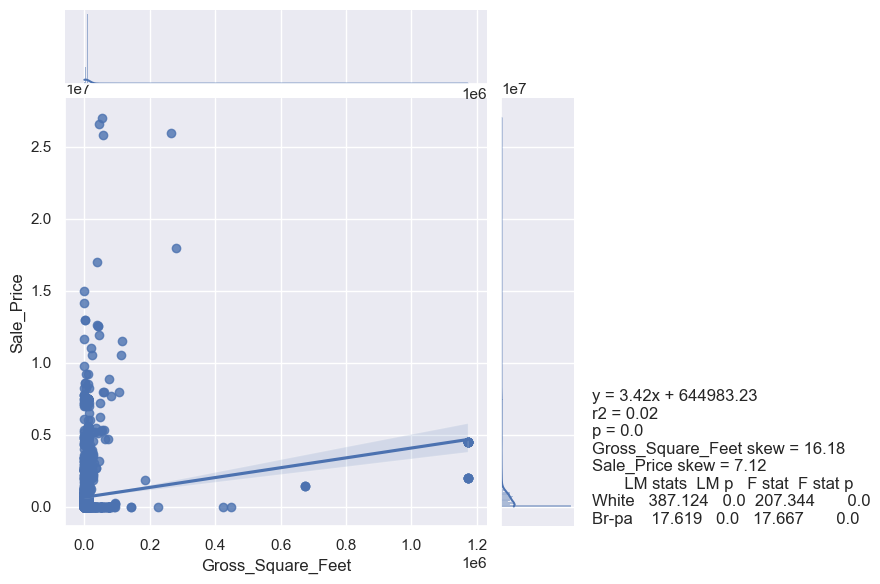

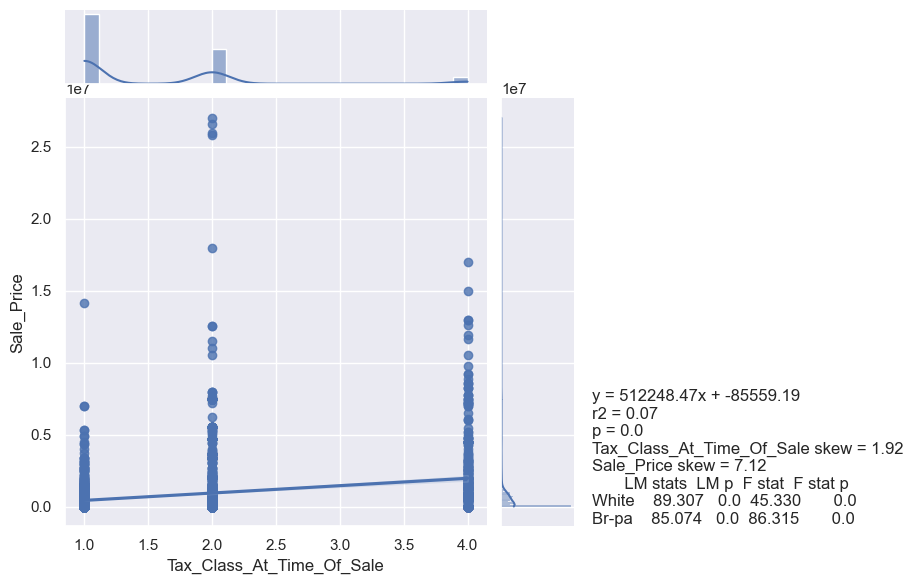

,Stat,+/-,Effect size,p-value
Tax_Class_At_Time_Of_Sale,r,1.0,0.267,0.000000
Residential_Units,r,1.0,0.258,0.000000
Total_Units,r,1.0,0.245,0.000000
Gross_Square_Feet,r,1.0,0.157,0.000000
Commercial_Units,r,1.0,0.121,0.000000
Land_Square_Feet,r,1.0,0.120,0.000000
Zip_Code,r,-1.0,0.059,0.000006
Lot,r,-1.0,0.057,0.000015
Block,r,1.0,0.020,0.131926
Tax_Class_At_Present,F,,61.108,0.000000


In [147]:
#BiVariate: Numeric to Numeric: COrelation
#BiVariate: Numeric to Categorical: one-way ANOVA (3+ groups) or t-test (2 groups)
#BiVariate: Categorical to Categorical: Chi-square
def bivariate_stats(df, label):
    output_df = pd.DataFrame(columns=['Stat', '+/-', 'Effect size', 'p-value'])
    for col in df:
        if not col == label:
            if df[col].isnull().sum() == 0 :
                if pd.api.types.is_numeric_dtype(df[col]):
                    r, p = stats.pearsonr(df[label] , df[col])
                    output_df.loc[col] = ['r', np.sign(r), abs(round(r,3)), round(p,6)]
                    scatter(df[col], df[label])
                else:
                    F, p = anova(df[[col, label]], col, label)
                    output_df.loc[col] = ['F', '', round(F,3), round(p,6)]
            else:
                output_df.loc[col] = [np.nan, np.nan, np.nan, 'nulls']
    return output_df.sort_values(by=[ 'Stat', 'Effect size'], ascending=False)
bivariate_stats(df, 'Sale_Price')